In [1]:
# import
import os, sys, shutil, pickle
import numpy as np
import pandas as pd
import scipy as sp
import nibabel as nib
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
from snaplab_tools.utils import threshold_consistency, normalize_x
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

## Load data

In [2]:
in_dir = '/media/lindenmp/storage_ssd_1/research_data/HCP_YA/collated_outputs'

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

### Connectome

In [3]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_connectome.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [4]:
subject_ids = list(data.keys())
n_subs = len(subject_ids)
n_subs

962

In [5]:
subject_filter = np.zeros(n_subs).astype(bool)

In [6]:
parc_dir = '/media/lindenmp/storage_ssd_1/research_data/HCP_YA/derivatives/parcellations'

A = np.zeros((n_parcels, n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        adj = data[subject_ids[i]][atlas].copy()
        
        in_file = os.path.join(parc_dir, '{0}/{0}_atlas-{1}_space-T1w_res-1_regionsizes.txt'.format(subject_ids[i], atlas))
        voxel_counts = np.loadtxt(in_file, dtype=int)
        voxel_counts = normalize_x(voxel_counts)
        size_matrix = np.add.outer(voxel_counts, voxel_counts) / 2
        adj = np.divide(adj, size_matrix)
        adj_mask = adj > 0
        adj[adj_mask] += 1
        adj = np.log(adj, out=np.zeros_like(adj), where=(adj != 0))

        A[:, :, i] = adj
    except:
        subject_filter[i] = True

/tmp/ipykernel_2370911/109108200.py:13: RuntimeWarning: invalid value encountered in divide
  adj = np.divide(adj, size_matrix)


### fmri

In [7]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_rsfmri.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [8]:
rsts = np.zeros((1200, n_parcels, 1, n_subs))

for i in np.arange(n_subs):
    try:
        ts = data[subject_ids[i]][atlas]['rfMRIREST1LR'].copy()
        
        gs = np.mean(ts, axis=1).reshape(-1, 1)
        gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
        nuis = np.concatenate((gs, gs_diff), axis=1)
        nuis = np.concatenate((nuis, np.square(nuis)), axis=1)

        regr = LinearRegression()
        regr.fit(nuis, ts)
        y_pred = regr.predict(nuis)
        ts = ts - y_pred
        
        # z score
        ts = sp.stats.zscore(ts, axis=0)
        
        rsts[:, :, 0, i] = ts
    except:
        subject_filter[i] = True

### myelin

In [9]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_myelin.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [10]:
myelin = np.zeros((n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        myelin[:, i] = data[subject_ids[i]][atlas]
    except:
        subject_filter[i] = True

## Filter

In [11]:
np.asarray(subject_ids)[subject_filter]

array(['119833', '284646'], dtype='<U6')

In [12]:
A = A[:, :, ~subject_filter]
rsts = rsts[:, :, :, ~subject_filter]
myelin = myelin[:, ~subject_filter]

print(A.shape, rsts.shape, myelin.shape)

(400, 400, 960) (1200, 400, 1, 960) (400, 960)


In [13]:
Am = threshold_consistency(A, thr=0.6)
print(Am.shape)

(400, 400)


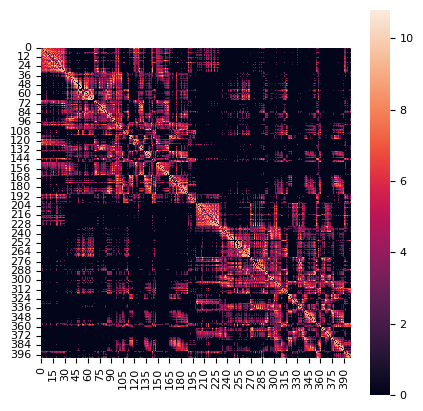

In [14]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(Am, ax=ax, square=True)
plt.show()

In [15]:
np.count_nonzero(np.triu(Am)) / ((Am.shape[0] ** 2 - Am.shape[0]) / 2)

0.3286842105263158

## Save

In [16]:
# save
file_str = '/home/lindenmp/research_projects/nct_xr/data/HCPYA_{0}_A.npy'.format(atlas)
np.save(file_str, A)
file_str = '/home/lindenmp/research_projects/nct_xr/data/HCPYA_{0}_Am.npy'.format(atlas)
np.save(file_str, Am)

file_str = '/home/lindenmp/research_projects/nct_xr/data/HCPYA_{0}_rsts.npy'.format(atlas)
np.save(file_str, rsts)

file_str = '/home/lindenmp/research_projects/nct_xr/data/HCPYA_{0}_myelin.npy'.format(atlas)
np.save(file_str, myelin)